# Understanding Beta
Beta is an important concept when studying relations between assets, or between a portfolio and its benchmark. Its most important use is in the Capital Asset Pricing Model. That is:
$$E(r_i)=r_f+\beta_i\cdot\big(E(r_m)-r_f\big)$$
where:
- $E(r_i)$ is the expected return on the capital asset
- $r_f$ is the risk-free rate of return
- $\beta_i$ is the sensitivity of the expected excess asset returns to the expected excess market returns
- $E(r_m)$ is the expected return of the market

Our $\beta_i$ is defined as how much the asset moves relative to the market. If for example, the market moves 1 percent and the asset moves 2 percent, $\beta_i$ is said to be 2. Note the importance of measuring changes taking percentages instead of raw prices. One can also take the differences of logarithms. The easiest way to calculate $\beta_i$ is:<br>
$$\beta_i=\frac{Cov(r_i,r_m)}{Var(r_m)}$$
where:
- $Cov(r_i,r_m)$ is the covariance between the asset returns (percentage) and the market returns (percentage)
- $Var(r_m)$ is the variance of the market returns (percentage)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from Functions import getdata, kalman
from statsmodels.tsa.stattools import adfuller
import scipy.stats as st

### Data model
The first step in our beta study is to build an accurate model of a synthetic asset in a virtual market. In such a model it is essential to vary the beta on request. It is also desirable including some noise in that beta, so the subsequent calculus is more realistic.<br>
The data model starts with two identical time series, called *Market* and *Asset*. Then we calculate the percentage return of the Asset to meet the beta directive plus some noise. Finally, we added the option of inserting lags to the asset so that the linked returns of the Market-Asset do not coincide in the same day.<br>
Note that an independent parameter has been inserted. This will be useful when trying to find the beta of a non-correlated pair (market-asset).

In [2]:
def build_model(start_date, end_date, beta = 2, start_price_market = 100, 
                start_price_asset = 80, sigma_noise = 0.1, shift = 0, mu=0, sigma=1, independent = False):
    dates = pd.bdate_range(start_date, end_date)
    names = ['Market', 'Asset']
    rets = start_price_market+np.cumsum(np.random.normal(mu,sigma, size = dates.size))#random time serie
    pct_ret1 = (rets[1:]/rets[:-1])-1 #calculating percentage returns
    pct_ret1 = np.concatenate((np.asarray([start_price_market]),pct_ret1))
    if independent:
        rets2 = start_price_asset+np.cumsum(np.random.normal(mu,sigma, size = dates.size))#random time serie
        pct_ret2 = (rets2[1:]/rets2[:-1])-1 #calculating percentage returns
        pct_ret2 = np.concatenate((np.asarray([start_price_asset]),pct_ret2))
    else:
        pct_ret2 = (pct_ret1*beta)+np.random.normal(0,sigma_noise, size = dates.size)#adding noise to beta
    price1=[start_price_market]
    price2=[start_price_asset]
    for i in range(1,len(pct_ret1)):#regenerating prices againg from their percentage returns
        price1 += [price1[i-1]+price1[i-1]*pct_ret1[i]]
        price2 += [price2[i-1]+price2[i-1]*pct_ret2[i]]
    if shift == 0:
        prices = np.array((np.asarray(price1),np.asarray(price2)))
    else:#adding a phase shift to the asset
        prices = np.array((np.asarray(price1)[shift:],np.asarray(price2)[:-shift]))
    return pd.DataFrame(prices.transpose(), index=dates[shift:] , columns = names)

In [3]:
COMB = build_model(start_date = '2016-01-01', end_date='2018-12-31',beta = 0.9, sigma_noise = 0.01, shift = 0, mu = 0.1)

We can now plot our simulated universe. Depending on the parameters, we can see different results.

Text(0,0.5,'Price ($)')

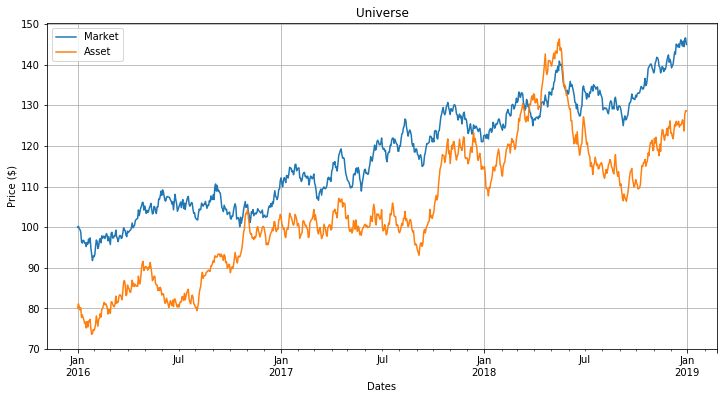

In [4]:
ax = COMB.plot(figsize=[12,6], grid= True, title ='Universe')
ax.set_xlabel('Dates')
ax.set_ylabel('Price ($)')

### Computing Beta
As seen in the beta [formula](#Understanding-Beta), beta calculation is easy once having the covariance matrix. Then, the calculation is trivial, as follows: 

In [5]:
def Beta(pair):
    Market = pair.columns.values[0]
    Asset = pair.columns.values[1]
    cov_matrix = np.cov(pair[Market], pair[Asset])
    return cov_matrix[0,1]/cov_matrix[0,0]

In [6]:
print('Beta: %.2f'%Beta(COMB.pct_change().dropna()))

Beta: 0.91


Another way to look at beta is graphically. In a scatter plot (Asset returns Vs. Market returns), beta is the slope of the line that relates both returns more accurately. The easiest way to calculate such a line is through Ordinary Least Squares which calculates the line that minimizes the overall distance from the line to every single point.

In [7]:
def PlotBeta(pair):
    Market = pair.columns.values[0]
    Asset = pair.columns.values[1]
    returns = pair.pct_change().dropna()
    log_rets = (np.log(pair)-np.log(pair.shift(1))).dropna()
    #fig, ax = plt.subplots(figsize = [15,6])
    ax=returns.plot(kind = 'scatter', x=Market, y = Asset, figsize=[12,6], grid = True, title='Scatter Plot')
    ax.set_xlabel(Market + ' change (%)')
    ax.set_ylabel(Asset + ' change (%)')
    LEASTSQUARES = sm.OLS(returns[Asset], sm.add_constant(returns[Market])).fit()
    beta = LEASTSQUARES.params[1]
    alpha = LEASTSQUARES.params[0]
    ax.plot(returns[Market], returns[Market]*beta+alpha,'-', color = 'r')
    print('beta: %.2f, R-Squared: %.2f'%(beta, LEASTSQUARES.rsquared))

beta: 0.91, R-Squared: 0.42


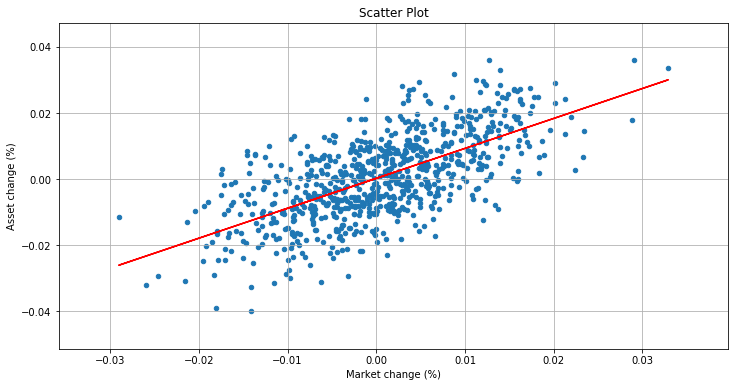

In [8]:
PlotBeta(COMB)

### Stationarity test
The first thing that one should ask is, Is Beta stationary?. To test it we need to have successive beta samples.

In [9]:
def rolling_beta(pair, window_size=30):
    beta_list = [Beta(pair.pct_change().dropna().iloc[i:i+window_size]) for i in range(len(pair)-window_size)]
    beta_list = [np.nan]*window_size+beta_list
    beta = pd.Series(beta_list, index = pair.index, name = str(window_size)+' days mean')
    return beta

Text(0,0.5,'Beta')

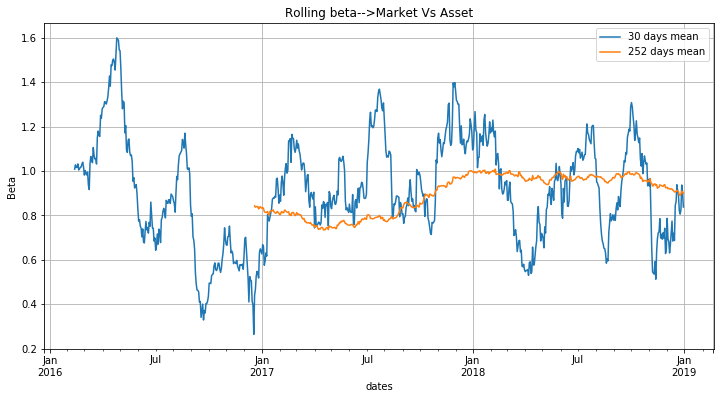

In [10]:
Market = COMB.columns.values[0]
Asset = COMB.columns.values[1]
fast_window = 30
slow_window = 252
beta_fast = rolling_beta(COMB, fast_window)
beta_slow = rolling_beta(COMB, slow_window)
both_beta = pd.DataFrame([beta_fast, beta_slow]).transpose()
ax = both_beta.plot(figsize = [12,6], grid = True, title = 'Rolling beta-->'+str(Market) +' Vs '+ str(Asset))
ax.set_xlabel("dates")
ax.set_ylabel("Beta")

Now, we can perform an Augmented Dickey-Fuller test:

In [11]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(beta_fast.dropna())
print('p-value: %f' % result[1])

p-value: 0.004800


In this case, we can reject the null hypothesis in favor of the alternative. Id est, beta is stationary. It is not surprising since the [model](#Data-model) does so. Before moving on a real example let's see what happens when the asset is not correlated with the market:

beta: -0.05, R-Squared: 0.00


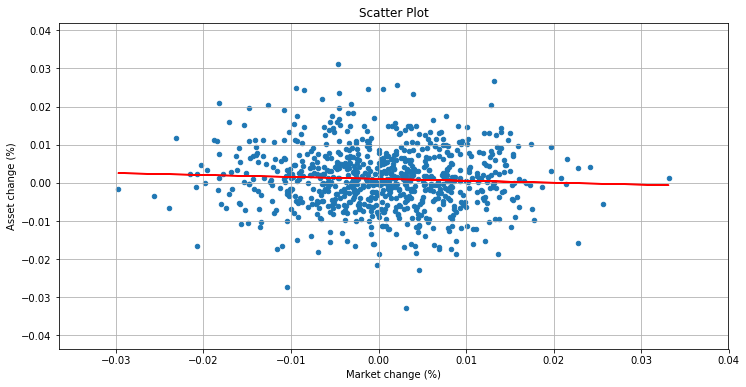

In [12]:
INDEP = build_model(start_date = '2016-01-01', end_date='2018-12-31',beta = 2, 
                   sigma_noise = 0.01, mu = 0.1, independent = True)
PlotBeta(INDEP)

The key here is understanding r-squared. A very low r-squared mean great dispersion of samples (as we can see above), so the red line (fitted model) does not represent the relationship between asset and market. Under these circumstances, the obtained value of beta should be discarded since it is meaningless. Another scenario would we one where the asset returns were lagged from market returns. It still had a strong beta relationship but shifted in time as shown below:

beta: 0.06, R-Squared: 0.00


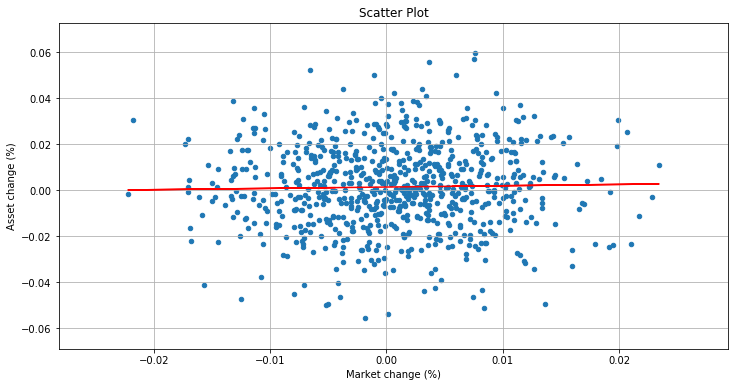

In [13]:
LAGGED = build_model(start_date = '2016-01-01', end_date='2018-12-31',beta = 2, 
                   sigma_noise = 0.01, mu = 0.1, independent = False, shift = 1)
PlotBeta(LAGGED)

It seems as if there was not any relationship, but if we take into account the lag:

beta: 2.05, R-Squared: 0.71


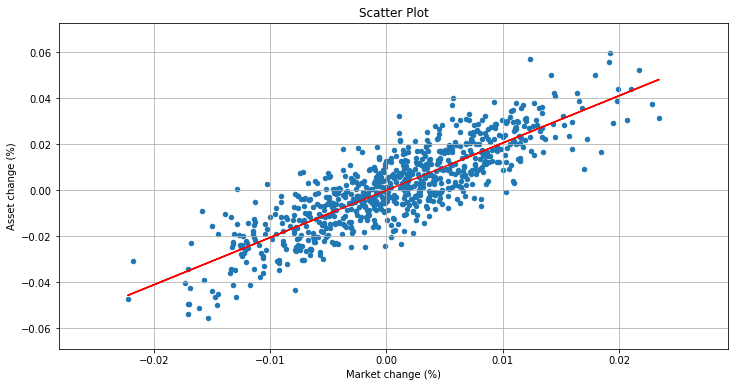

In [14]:
LAGGED['Asset'] = LAGGED['Asset'].shift(-1)
PlotBeta(LAGGED)

## Real pricing example
We have chosen a well-known pair of ETF's: The SP500 index tracker (SPY) and the nasdaq100 index tracker (QQQ). They are highly correlated, and it is known that QQQ carries more volatility than SPY. Given that, we should expect a beta value greater than 1. Let's see what the numbers are:

Text(0,0.5,'Price ($)')

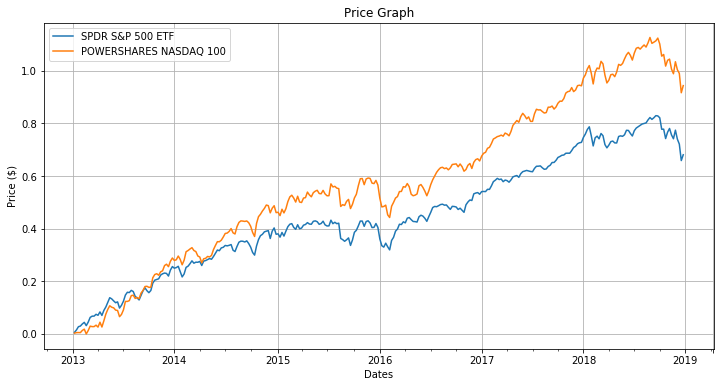

In [16]:
DS1 = getdata('SPY', '2013-01-01', '2018-12-31')
DS2 = getdata('QQQ', '2013-01-01', '2018-12-31')
REAL = pd.concat([DS1,DS2],axis = 1).resample('7d').mean()
ax=REAL.pct_change().dropna().cumsum().plot(figsize=[12,6], grid = True, title='Price Graph')
ax.set_xlabel('Dates')
ax.set_ylabel('Price ($)')

beta: 1.12, R-Squared: 0.83


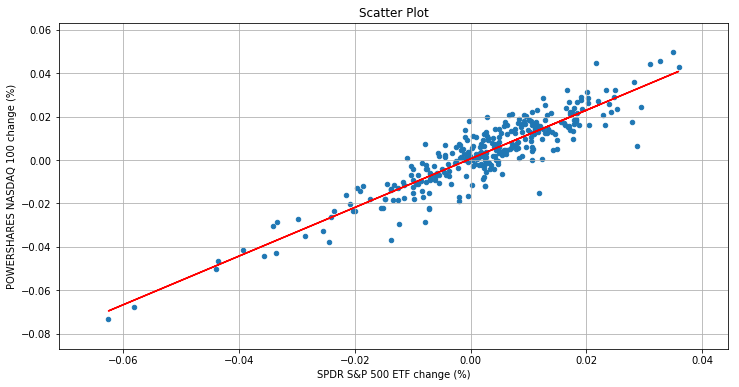

In [17]:
PlotBeta(REAL)

As we previously predicted, they have a strong relationship and $\beta$>1. The R-Squared parameter tells us how well the red line represents (fit) the relation of the returns. Our next step will be checking again for stationarity on the beta signal. To do so, we will compute the rolling beta as before:

Text(0,0.5,'Beta')

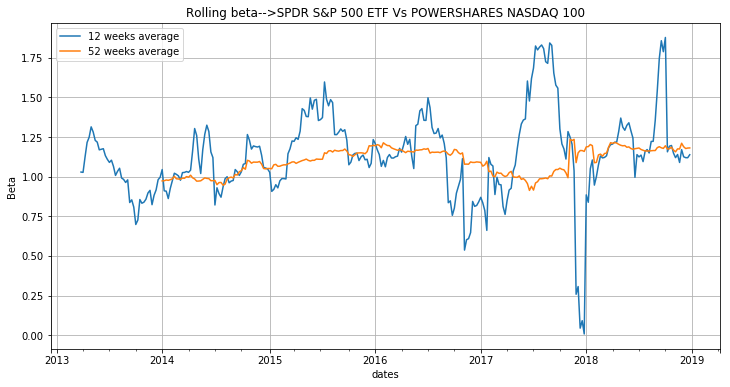

In [18]:
Market = REAL.columns.values[0]
Asset = REAL.columns.values[1]
fast_window = 12
slow_window = 52
rbeta_fast = rolling_beta(REAL, fast_window)
rbeta_slow = rolling_beta(REAL, slow_window)
rbeta_fast.name = str(fast_window)+' weeks average'
rbeta_slow.name = str(slow_window)+' weeks average'
both_beta = pd.DataFrame([rbeta_fast, rbeta_slow]).transpose()
ax = both_beta.plot(figsize = [12,6], grid = True, title = 'Rolling beta-->'+str(Market) +' Vs '+ str(Asset))
ax.set_xlabel("dates")
ax.set_ylabel("Beta")

In [19]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(rbeta_slow.dropna())
print('p-value: %f' % result[1])

p-value: 0.414839


The ADF p-value shows that there is not much statistical relevance to reject the null hypothesis, so beta **is not stationary.** That means that its mean and standard deviation change over time. We need to build a mechanism that detects when this change is statistically significative. 

## Histogram study
The first thing to do is having a look at the histogram of beta, and test whether it is normally distributed or not.

p value of normality test: 0.0003


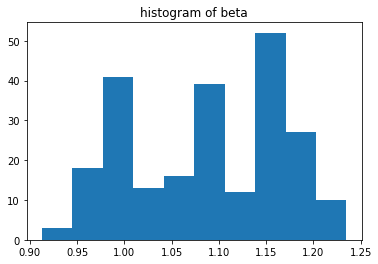

In [20]:
samples_per_mean = 30
population = rbeta_slow.dropna()[:-samples_per_mean]
sample = rbeta_fast.dropna()[-samples_per_mean:]#we reserve some data to test
plt.hist(population);
plt.title('histogram of beta')
t, p = st.jarque_bera(population)
print('p value of normality test: %.4f'%p)

#### Box Cox Transformation
The bad news is that the histogram is not standard since we could easily reject the null hypothesis of the Jarque-Bera test. We can use a cox-box transformation and see if we can make the above distribution normal. The Box-Cox algorithm tries to convert a non-normal distribution in a normal one. To do that it analyzes the data and tries to estimate the transformation factor $\lambda$ that better fits a normal distribution.<br> Once having the right $\lambda$, the transformation goes as follows:
$$ 
x'=\begin{cases}
    \frac{x^\lambda -1}{\lambda} & \text{if $\lambda \neq 0$}.\\
    log(x) & \text{if $\lambda = 0$}.
  \end{cases} $$

p value of normality test: 0.0004


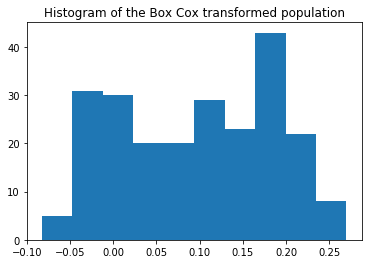

In [21]:
bc, maxlog, interval = st.boxcox(population, alpha=.005)
plt.hist(bc);
plt.title('Histogram of the Box Cox transformed population')
t, p = st.jarque_bera(bc);
print('p value of normality test: %.4f'%p)

As we can see above, the new histogram is far from being normal as both visual inspection and Jarque-Bera test show.

#### Sample means test
According to the central limit theorem (CLT), the distribution of sample means becomes normal as the number of samples increases. This normal distribution has mean  $M \approx \mu$ and a standard error $SE=\dfrac{\sigma}{\sqrt{n}}$. 
  So, the population mean would be simply the sample mean and standard deviation $s = SE\cdot\sqrt{n}\approx \sigma$ 
To solve that, one can repeat the above exercise but taking the sample means instead of the samples.

In [22]:
sample_means = population.rolling(samples_per_mean).mean().dropna()
M = sample_means.mean()
SE = sample_means.std()
print('M: %.4f, Population mu : %.4f, Population Sigma: %.4f' %(M, population.mean(), population.std()))
print('SE: %.4f'%SE)

M: 1.0892, Population mu : 1.0883, Population Sigma: 0.0808
SE: 0.0649


Text(0.5,1,'Histogram of the sample means picked as they come')

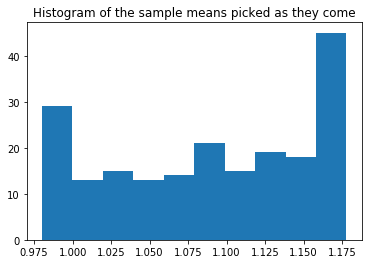

In [23]:
plt.hist(sample_means);
plt.title('Histogram of the sample means picked as they come')

What happened with the normal histogram we were expecting? Didn't the CLT work at all? The CLT assumes that we **randomly** pick samples to obtain sample distribution. Nevertheless, our dataset is very special because the correlation coefficient moves in clusters. That means that if we take 20 consecutive values, it is likely they are a very close one to each other. The only way we can generate a normal sample distribution is if we performed the following:

Mean: 1.0892
SE: 0.0160
Estimated Population Sigma: 0.0878, real population sigma 0.081
p value of normality test: 0.1786


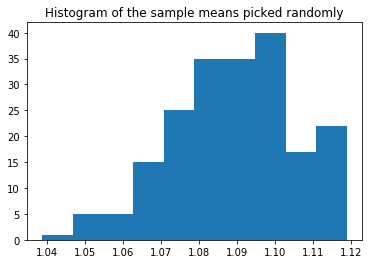

In [24]:
sample_means = np.random.choice(population, (samples_per_mean,200), replace = True).mean(axis=0)
plt.hist(sample_means)
plt.title('Histogram of the sample means picked randomly')
print('Mean: %.4f'%sample_means.mean())
print('SE: %.4f'%sample_means.std())
sigma = np.sqrt(samples_per_mean)*sample_means.std()
print('Estimated Population Sigma: %.4f, real population sigma %.3f'%(sigma, population.std()))
t, p = st.jarque_bera(sample_means) 
print('p value of normality test: %.4f'%p)

We can now see how the CLT applies. Nevertheless, although the normality test could not reject the null hypothesis, we cannot take random samples on a real data feed basis, since they will inevitably come in clusters as in previous plots.

#### Custom histogram estimation
Since our previous attempts to fit the data to a normal distribution have failed, we have to deal with our non-gaussian distribution. We can fit a custom histogram based on a Gaussian kernel estimation. Once we have that, we can easily find the critical values for a defined alpha level.

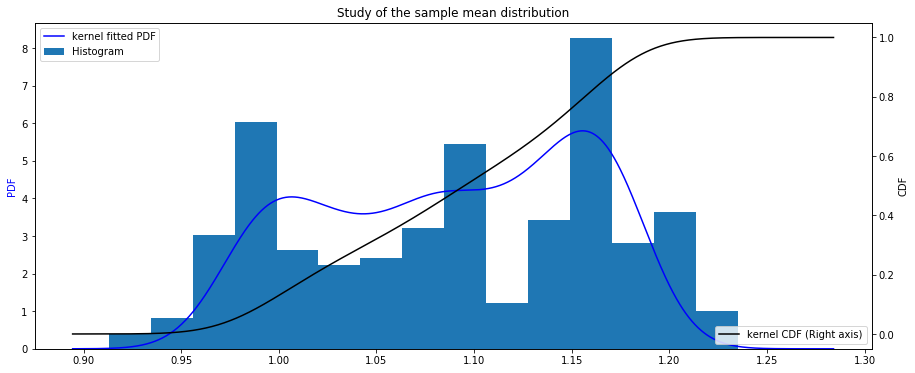

In [25]:
sample_means = population.rolling(samples_per_mean).mean().dropna()
M = sample_means.mean()
SE = sample_means.std()
x = np.linspace(M-3*SE, M+3*SE, 1000)
kernel = st.gaussian_kde(sample_means)
pdf_kernel = kernel.pdf(x)
cdf_kernel = np.cumsum(pdf_kernel)*(x[1]-x[0])
fig, ax1 = plt.subplots(figsize = [15,6])
plt.title('Study of the sample mean distribution')
plt.hist(population, density=True, bins=15, label='Histogram');
ax1.plot(x, pdf_kernel, label='kernel fitted PDF', color = 'b')
ax2 = ax1.twinx()
ax2.plot(x, cdf_kernel, label='kernel CDF (Right axis)', color = 'k')
ax1.set_ylabel('PDF', color='b')
ax2.set_ylabel('CDF', color='k')
leg = ax1.legend(loc = 'upper left');
leg2 = ax2.legend(loc = 'lower right');

Therefore the hypothesis test goes like this:
- H0 (null hypothesis): Beta sample comes from the studied normal distribution
- H1 (alternative hypothesis): Beta sample **comes from another** distribution with different means and standard deviation.

The alpha level will be 0.01.

In [26]:
idx_crit = list(np.round(cdf_kernel, 3)).index(0.006)#(0.01/2)+delta since index function finds the first occurence
crit_low=x[idx_crit]
idx_crit = list(np.round(cdf_kernel, 3)).index(0.995)
crit_up=x[idx_crit]
crit = np.asarray([crit_low, crit_up])
print('crit values: ' +str(crit))

crit values: [0.94742169 1.21463039]


Whenever we obtain a beta mean value above/below the critical values, we know we have a probability higher than 99% that beta mean comes from another distribution. That means that beta parameters have evolved and we should stop trading based on old parameters. Our mean and std deviation have changed as the Stationarity test predicted.<br>
Let's see what new sample data is like:

In [27]:
print('Sample data mean: %.3f'%sample.mean())

Sample data mean: 1.261


This new value is greater than the upper critical value (1.21), so it comes from another distribution.

## Conclussion
During this post, we have learned that [beta](#Understanding-Beta) is a key concept in the Capital Asset Pricing Model (CAPM). Much as important as beta itself, is the r-squared value of the fitted model (given a beta and alpha calculated via Ordinary Least Squares) tells us if beta is significative. Lower values of r-squared (<0.5) suggests calculated beta is not representative and we would have ended our study. <br>
On the other hand, if we get a reasonable r-squared value, we will find that beta [hardly ever is stationary](#Stationarity-test), so its mean and standard deviation change over time. It means that we have to deal with changing values and a complete histogram study need to be done.<br>
The shape of beta samples distribution [is not normal](#Histogram-study). The [Box Cox transformation](#Box-Cox-Transformation) have not succeeded in normalizing that histogram. Applying the [Central Limit Theorem](#Sample-means-test) did not help either since beta samples are highly dependant on its nearest neighbors and they are not randomly picked.<br>
If we wanted to know if a determined group of beta sample means come from a previously studied distribution, we need first to model that distribution with a [Gaussian kernel estimation](#Custom-histogram-estimation). Then calculating their critical values (asymmetric) for a determined critical value. Lastly, we have to compare the mean values of the new data with the previously calculated critical boundaries.<br>
The conclusions depicted in this post should be the foundation for any trading system or study based on beta or its derivatives. Hope it helped.

Julio García